In [37]:
# Eigene Funktionen
from core.data import clean_data, drop_columns, engineer_features, load_competition_from_kaggle, memory_data, TopNCategoriesTransformer

# Datenmanipulation
import pandas as pd
import numpy as np
import joblib
import os

# Visualisierung
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from xgboost import XGBClassifier

# Imbalanced-learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

# Hyperparameter Optimierung
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# Warnungen unterdrücken
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action="ignore", category=DataConversionWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

# Preparation

**Gather Data**

In [2]:
# Daten herunterladen (Kaggle Competition)
competition_name = "DontGetKicked"
destination = "../data/raw"

files = load_competition_from_kaggle(
    competition_name=competition_name,
    destination=destination,
)

# Trainingsdatei finden
train_file = [f for f in files if "training" in f.lower()][0]

# Einlesen der Daten
df = pd.read_csv("/".join([destination, competition_name, train_file]))
print(df.shape)
df.head()

Destination directory '../data/raw\DontGetKicked' already exists with files. Skipping download (replace=False).
(72983, 34)


,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


# Explorative Datenanalayse (EDA)

**Understand Data**


In [3]:
# Erste Übersicht über die Daten (Dimensions, Beschreibung, Duplikate)
display(
    "Shape",
    df.shape,
    "Description",
    df.describe().round(2).T,
    "Duplicates",
    df.duplicated().sum(),
)

# Übersicht über die Spalten (Datentypen, fehlende Werte, eindeutige Werte, Beispielwerte)
pd.DataFrame(
    {
        "Data Types": df.dtypes,
        "Missing Values": df.isnull().sum(),
        "Unique Values": df.nunique(),
        "Sample Values": [df[col].sample(3, random_state=42).tolist() for col in df.columns],
    }
)

'Shape'

(72983, 34)

'Description'

,count,mean,std,min,25%,50%,75%,max
RefId,72983.0,36511.43,21077.24,1.0,18257.5,36514.0,54764.5,73014.0
IsBadBuy,72983.0,0.12,0.33,0.0,0.0,0.0,0.0,1.0
VehYear,72983.0,2005.34,1.73,2001.0,2004.0,2005.0,2007.0,2010.0
VehicleAge,72983.0,4.18,1.71,0.0,3.0,4.0,5.0,9.0
WheelTypeID,69814.0,1.49,0.52,0.0,1.0,1.0,2.0,3.0
VehOdo,72983.0,71500.00,14578.91,4825.0,61837.0,73361.0,82436.0,115717.0
MMRAcquisitionAuctionAveragePrice,72965.0,6128.91,2461.99,0.0,4273.0,6097.0,7765.0,35722.0
MMRAcquisitionAuctionCleanPrice,72965.0,7373.64,2722.49,0.0,5406.0,7303.0,9021.0,36859.0
MMRAcquisitionRetailAveragePrice,72965.0,8497.03,3156.29,0.0,6280.0,8444.0,10651.0,39080.0
MMRAcquisitonRetailCleanPrice,72965.0,9850.93,3385.79,0.0,7493.0,9789.0,12088.0,41482.0


'Duplicates'

np.int64(0)

,Data Types,Missing Values,Unique Values,Sample Values
RefId,int64,0,72983,"[27871, 51624, 31955]"
IsBadBuy,int64,0,2,"[0, 0, 0]"
PurchDate,object,0,517,"[6/3/2009, 11/17/2009, 8/14/2009]"
Auction,object,0,3,"[MANHEIM, MANHEIM, OTHER]"
VehYear,int64,0,10,"[2003, 2004, 2005]"
VehicleAge,int64,0,10,"[6, 5, 4]"
Make,object,0,33,"[FORD, FORD, CHRYSLER]"
Model,object,0,1063,"[WINDSTAR FWD V6 3.8L, EXPLORER 4WD V6, PACIFI..."
Trim,object,2360,134,"[LX, XLS, Tou]"
SubModel,object,8,863,"[PASSENGER 3.8L LX, 4D SUV 4.0L FFV XLS, 4D SP..."


**Outliers Detection**


=== Auction ===
IsBadBuy      0     1
Auction              
ADESA     12246  2193
MANHEIM   36328  4715
OTHER     15433  2068


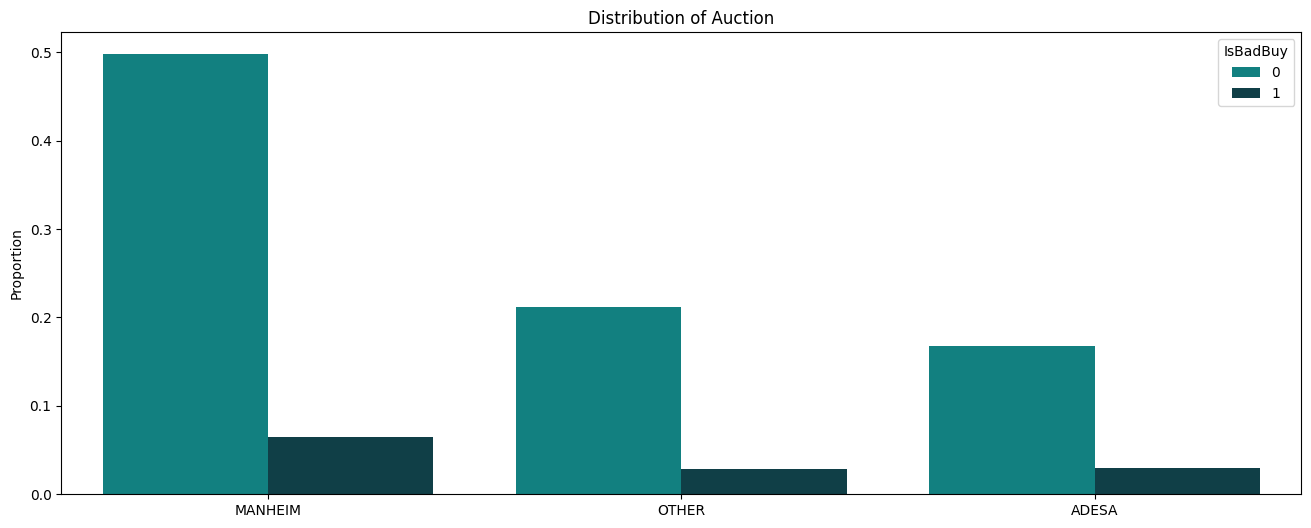


=== Transmission ===
IsBadBuy          0     1
Transmission             
AUTO          61722  8676
MANUAL         2276   299
Manual            1     0
Missing           8     1


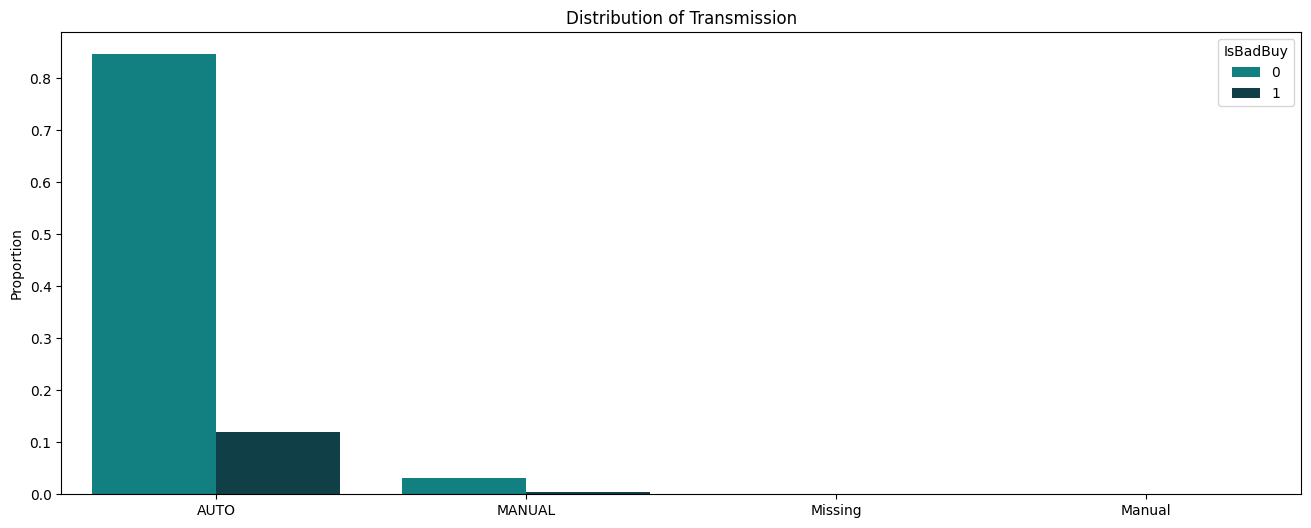


=== WheelTypeID ===
IsBadBuy         0     1
WheelTypeID             
0.0              4     1
1.0          32065  3985
2.0          30349  2655
3.0            656    99
Missing        933  2236


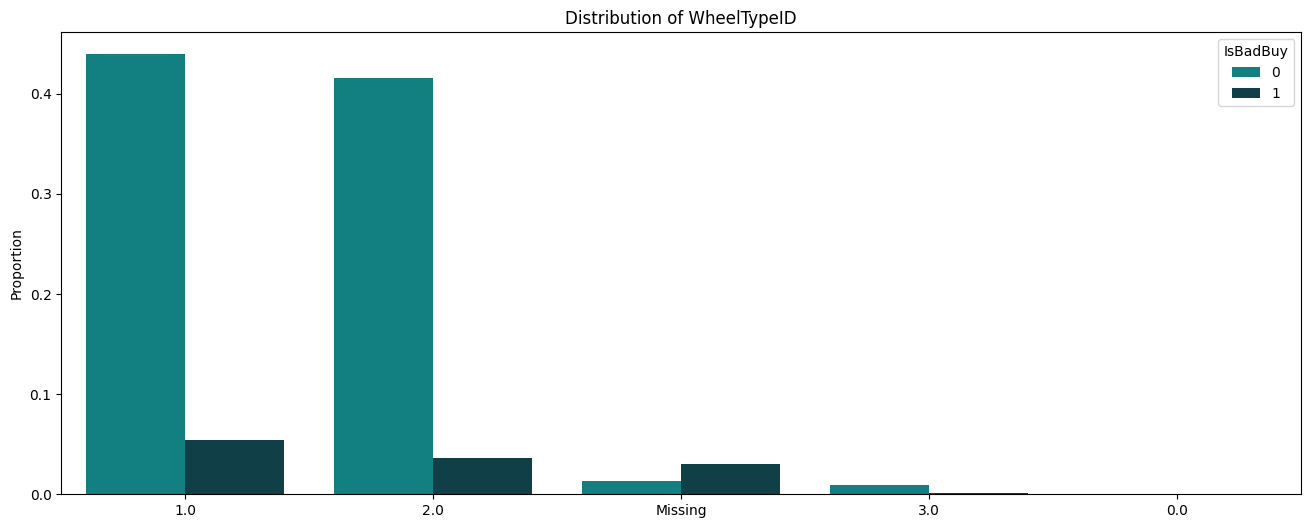


=== WheelType ===
IsBadBuy       0     1
WheelType             
Alloy      32065  3985
Covers     30349  2655
Missing      937  2237
Special      656    99


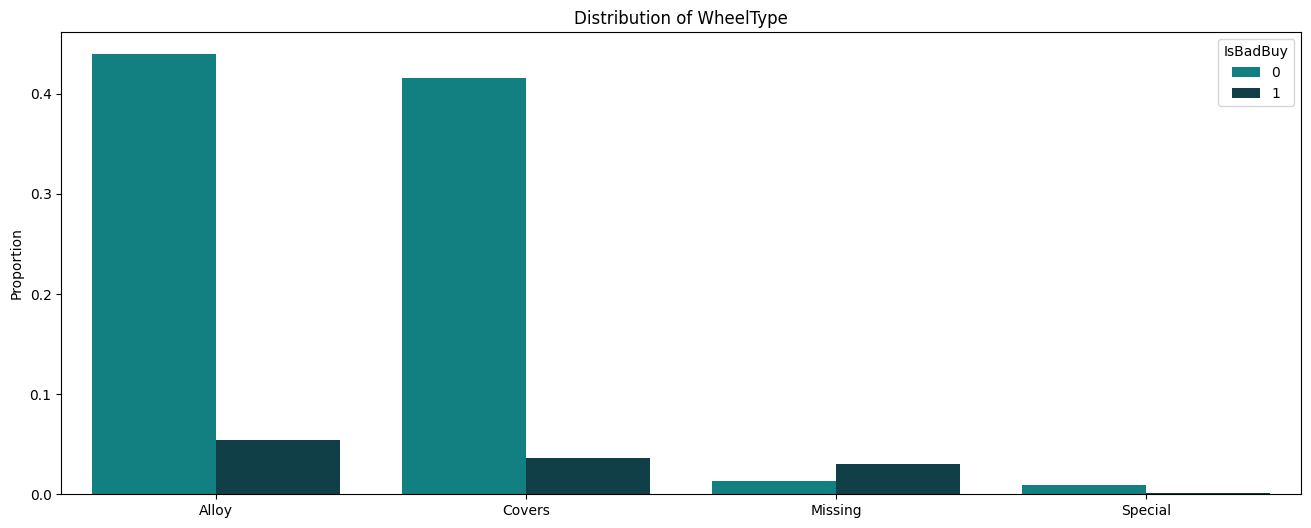


=== Nationality ===
IsBadBuy            0     1
Nationality                
AMERICAN        53641  7387
Missing             5     0
OTHER             168    27
OTHER ASIAN      6972  1061
TOP LINE ASIAN   3221   501


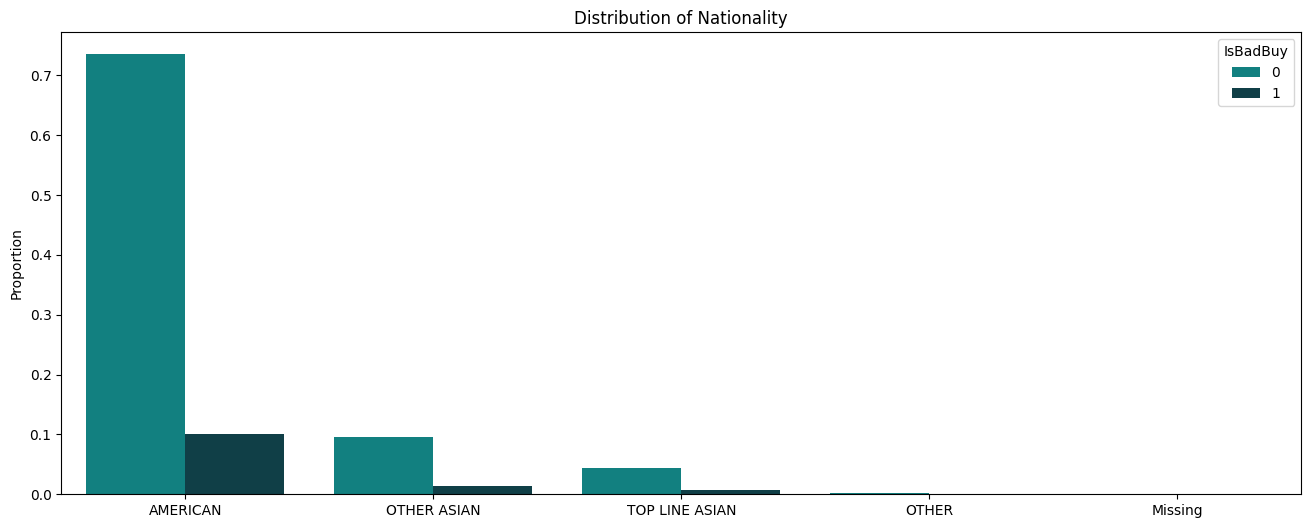


=== TopThreeAmericanName ===
IsBadBuy                  0     1
TopThreeAmericanName             
CHRYSLER              20674  2725
FORD                  10389  1926
GM                    22578  2736
Missing                   5     0
OTHER                 10361  1589


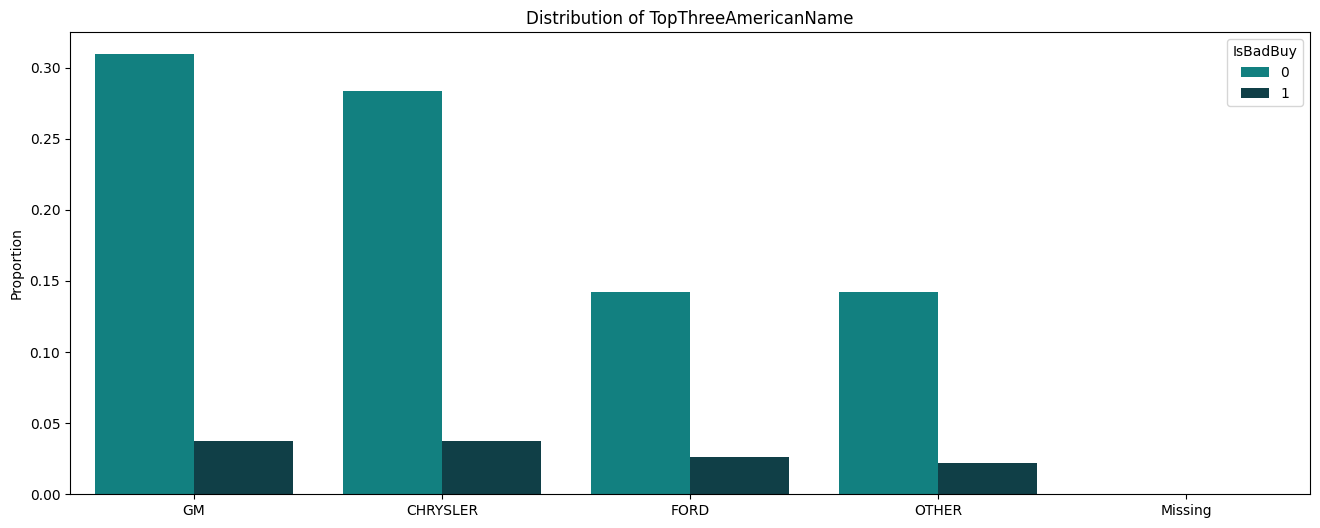


=== PRIMEUNIT ===
IsBadBuy       0     1
PRIMEUNIT             
Missing    60721  8843
NO          3230   127
YES           56     6


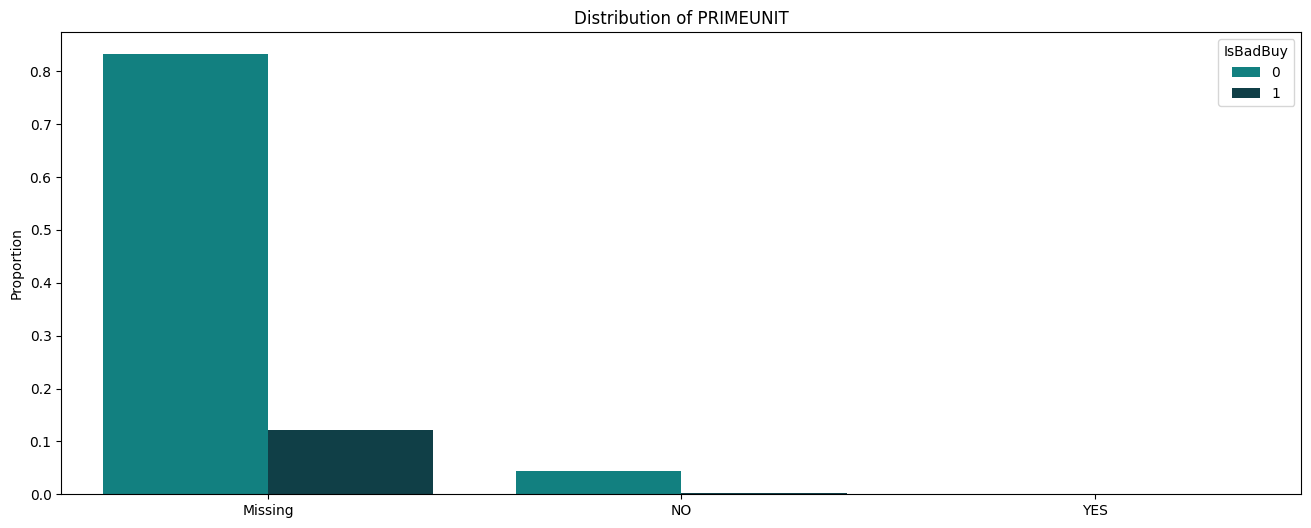


=== AUCGUART ===
IsBadBuy      0     1
AUCGUART             
GREEN      3215   125
Missing   60721  8843
RED          71     8


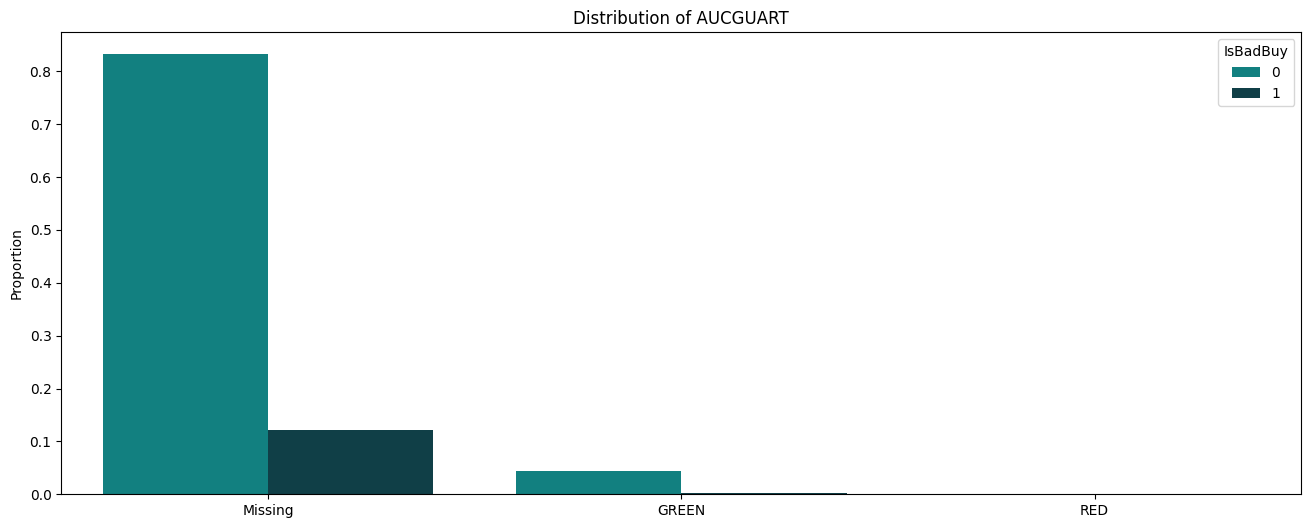


=== IsOnlineSale ===
IsBadBuy          0     1
IsOnlineSale             
0             62375  8763
1              1632   213


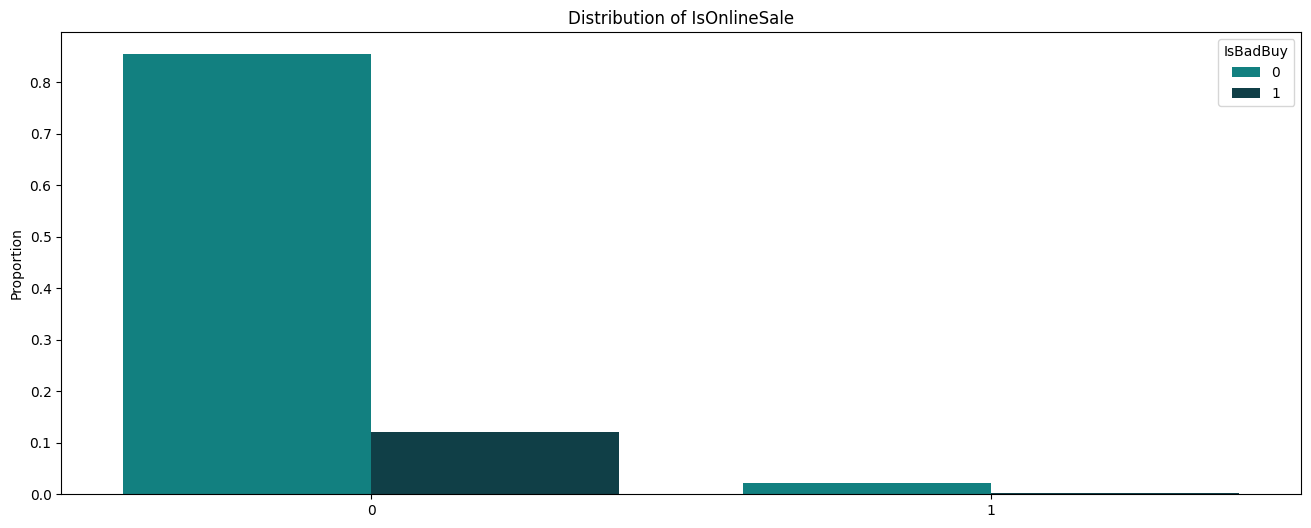

In [4]:
# Kategoriale Features: Verteilung nach Zielvariable
categorical_features = [
    "Auction",
    "Transmission",
    "WheelTypeID",
    "WheelType",
    "Nationality",
    "TopThreeAmericanName",
    "PRIMEUNIT",
    "AUCGUART",
    "IsOnlineSale",
]

for categorical_feature in categorical_features:
    # Füllen der fehlenden Werte mit "Missing"
    df_col = df[categorical_feature].fillna("Missing")

    # Kreuztabelle
    print(f"\n=== {categorical_feature} ===")
    print(pd.crosstab(df_col, df["IsBadBuy"]))

    # Visualisierung
    plt.figure(figsize=(16, 6))
    palette = ["#009292", "#074650"]
    sns.countplot(
        x=df_col,
        data=df,
        hue="IsBadBuy",
        stat="proportion",
        order=df_col.value_counts().index,
        palette=palette,
    )
    plt.title(f"Distribution of {categorical_feature}")
    plt.xlabel(None)
    plt.ylabel("Proportion")
    plt.show()


IsBadBuy       0     1
Make                  
CHEVROLET  15567  1681
CHRYSLER    7707  1137
DODGE      11579  1333
FORD        9563  1742
HYUNDAI     1578   233
JEEP        1390   254
KIA         2192   292
NISSAN      1752   333
Other       7071  1158
PONTIAC     3751   507
SATURN      1857   306


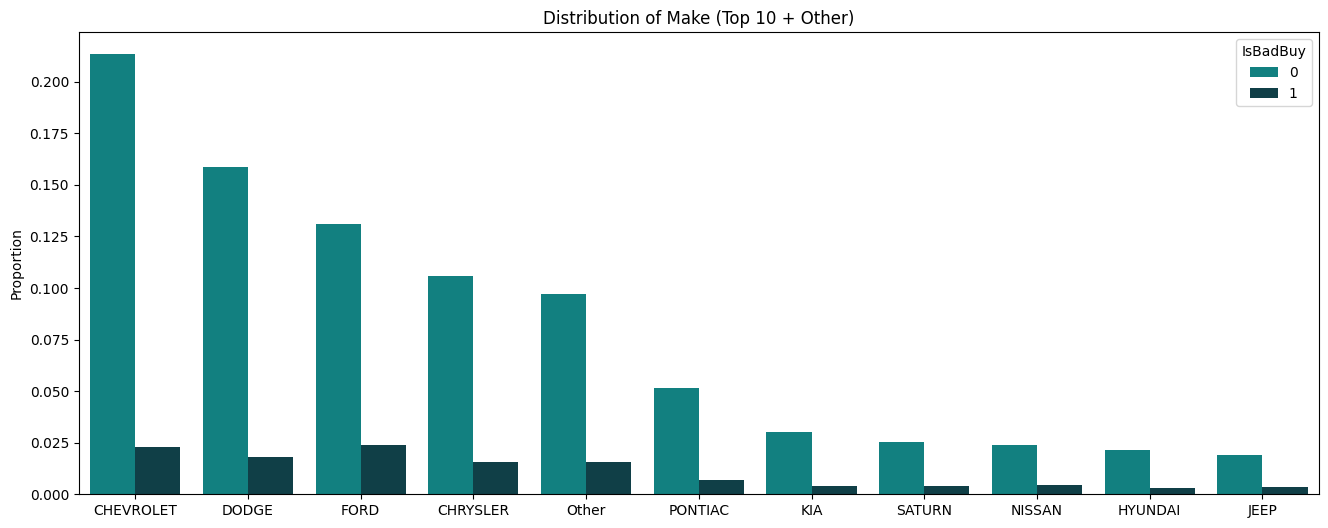

IsBadBuy      0     1
Color                
BEIGE      1373   211
BLACK      6769   858
BLUE       9158  1189
GOLD       4494   737
GREEN      2792   402
GREY       6976   911
MAROON     1786   260
Other      1578   234
RED        5432   825
SILVER    13032  1843
WHITE     10617  1506


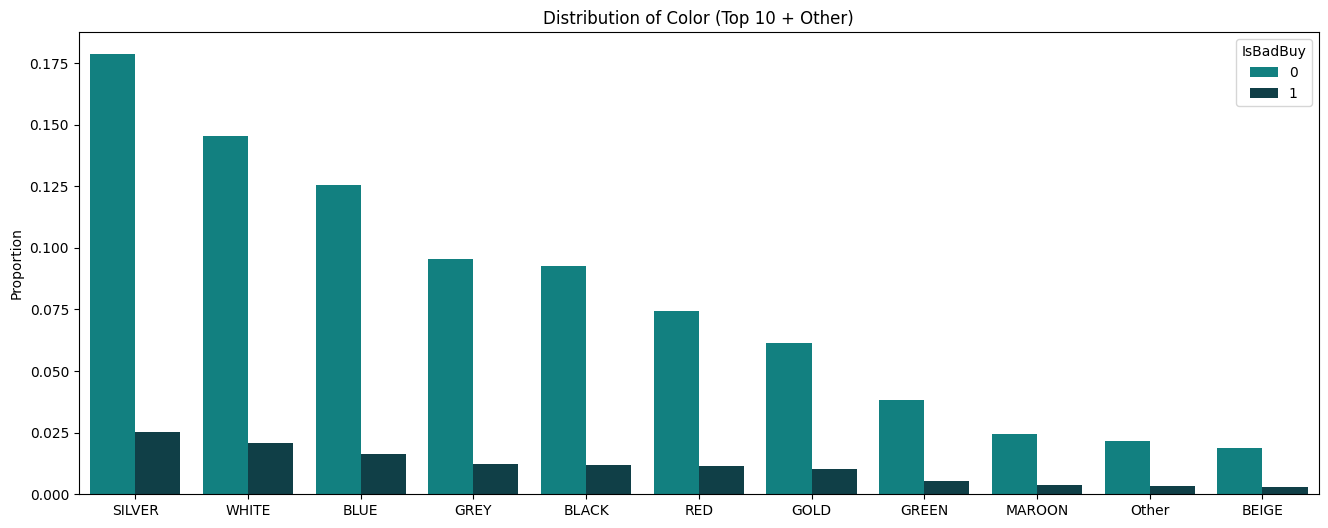

IsBadBuy         0     1
Size                    
COMPACT       6060  1145
CROSSOVER     1576   183
LARGE         8032   818
LARGE SUV     1201   232
LARGE TRUCK   2810   360
MEDIUM       27244  3541
MEDIUM SUV    6897  1193
Other         1377   269
SMALL SUV     1963   313
SPECIALTY     1739   176
VAN           5108   746


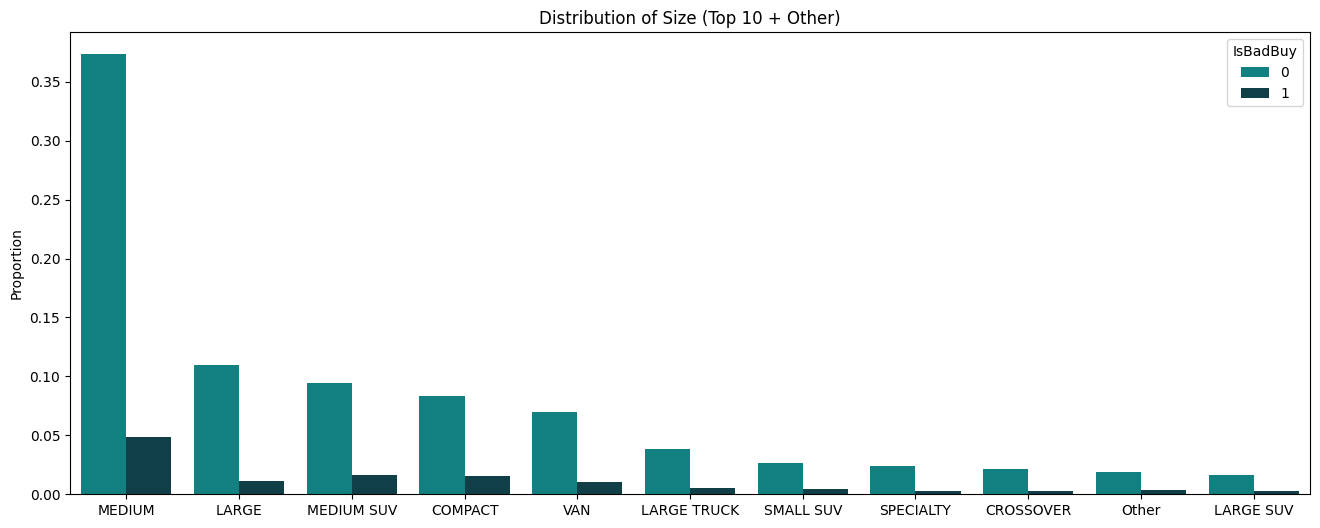

IsBadBuy      0     1
VNST                 
AZ         5470   704
CA         6144   951
CO         4394   604
FL         9305  1142
GA         2177   273
NC         6243   799
OK         3263   331
Other     10045  1498
SC         3686   594
TN         1561   203
TX        11719  1877


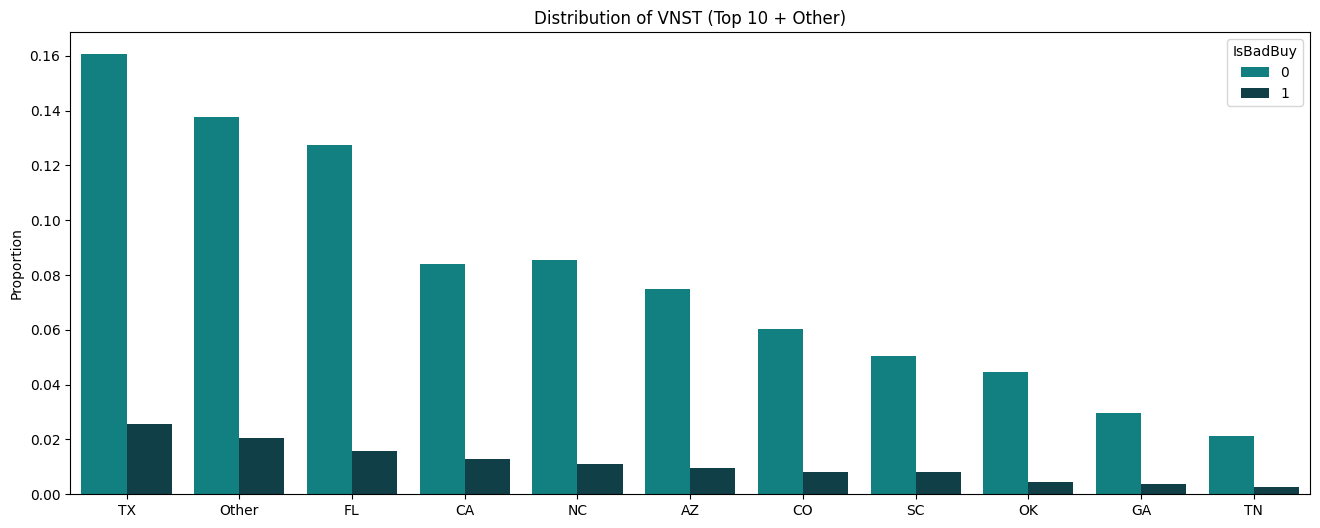

IsBadBuy                  0     1
Model                            
CALIBER                1232   143
CARAVAN GRAND FWD V6   1132   157
COBALT                  965   141
IMPALA                 1831   159
MALIBU 4C              1150    75
Other                 51527  7296
PT CRUISER             1893   436
PT CRUISER 2.4L I4 S    988   116
SEBRING 4C             1081    76
TAURUS                 1215   210
TAURUS 3.0L V6 EFI      993   167


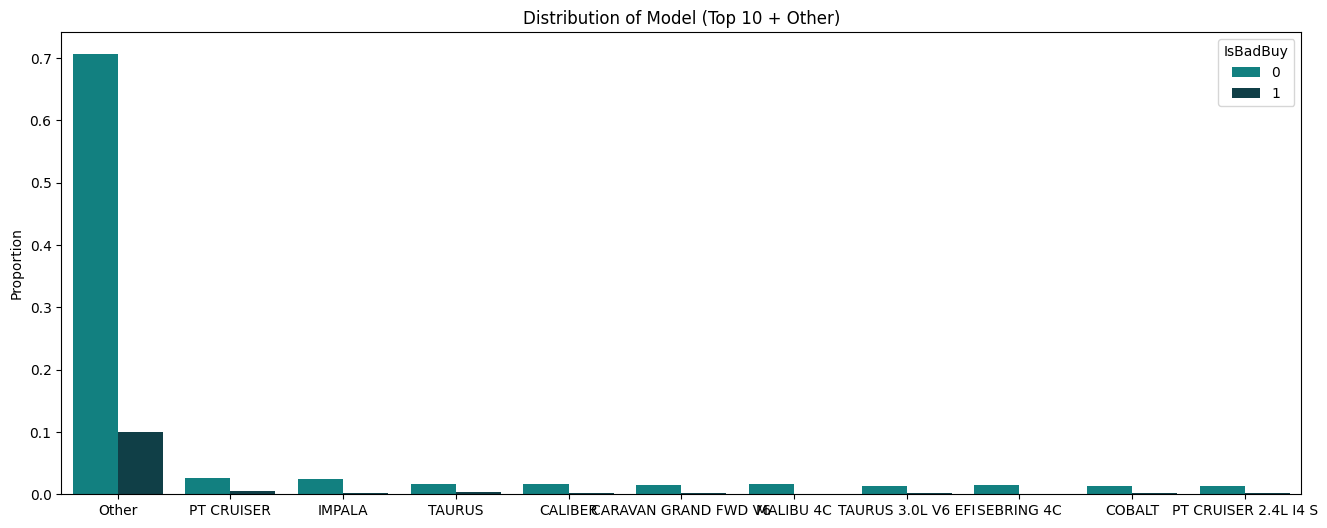

IsBadBuy      0     1
Trim                 
Bas       12223  1727
EX         1861   259
LS         9280   894
LT         3275   265
LX         2137   280
Other     18416  3217
SE         8199  1149
SEL        1231   129
SXT        3447   378
Tou        1952   304
nan        1986   374


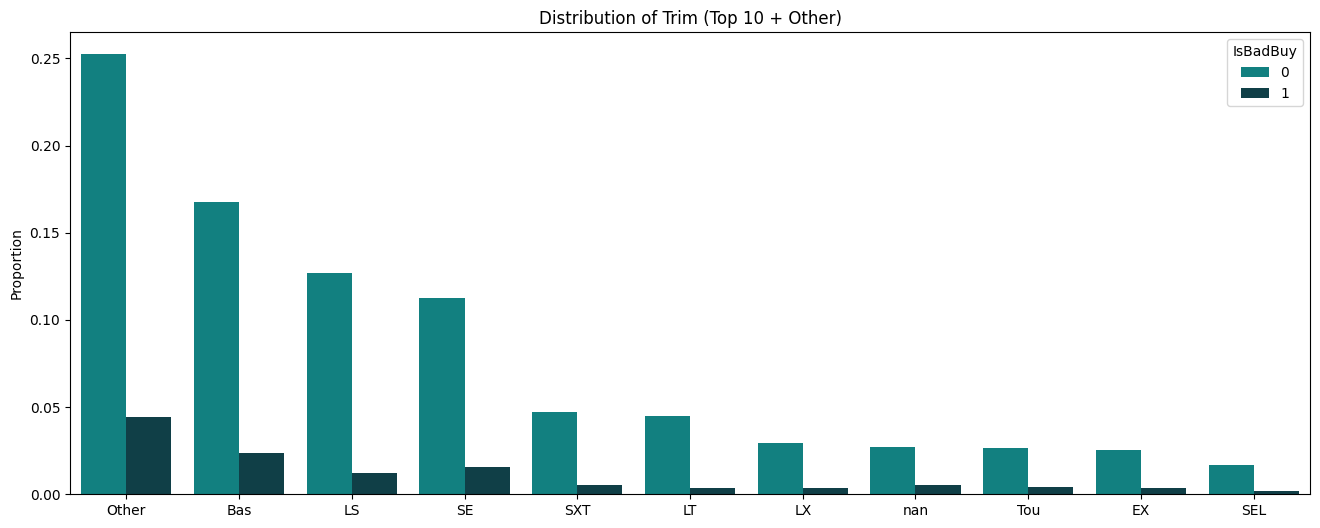

IsBadBuy              0     1
SubModel                     
2D COUPE            895   177
4D SEDAN          13373  1863
4D SEDAN LS        4353   365
4D SEDAN LT        1050    79
4D SEDAN LX         936   132
4D SEDAN SE        3344   515
4D SEDAN SXT FFV   1063    31
4D SUV 4.2L LS     1049   144
4D WAGON           2006   224
MINIVAN 3.3L       1133   125
Other             34805  5321


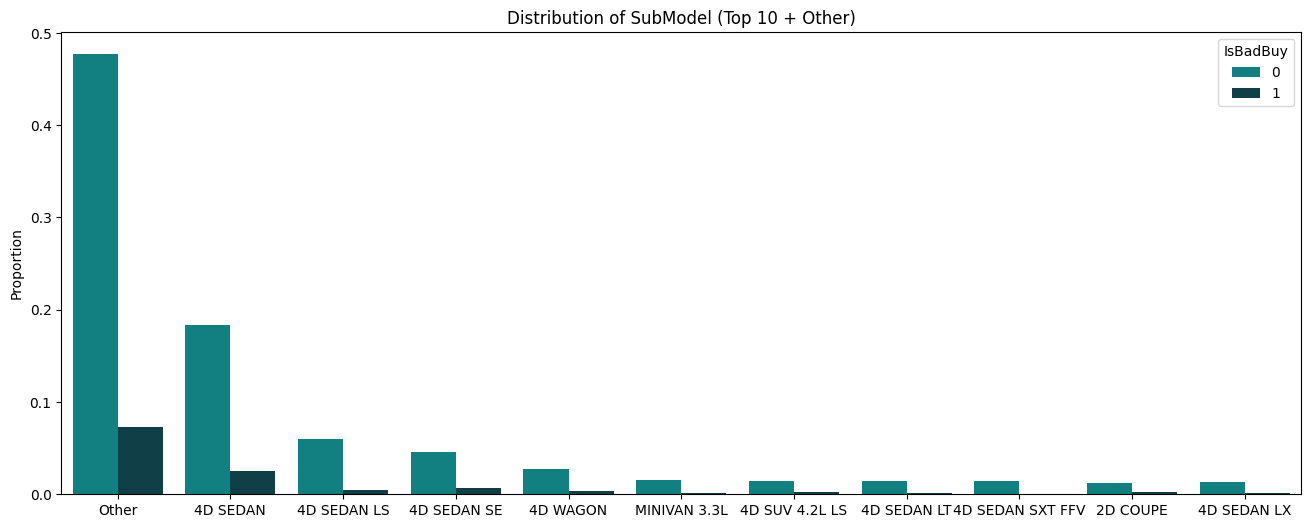

IsBadBuy      0     1
BYRNO                
17675      2253   364
18880      3047   541
19619      2420   318
20928      2330   256
21053      2439   377
22916      2465   387
3453       2596   331
835        2630   357
99750      2574    79
99761      3722   221
Other     37531  5745


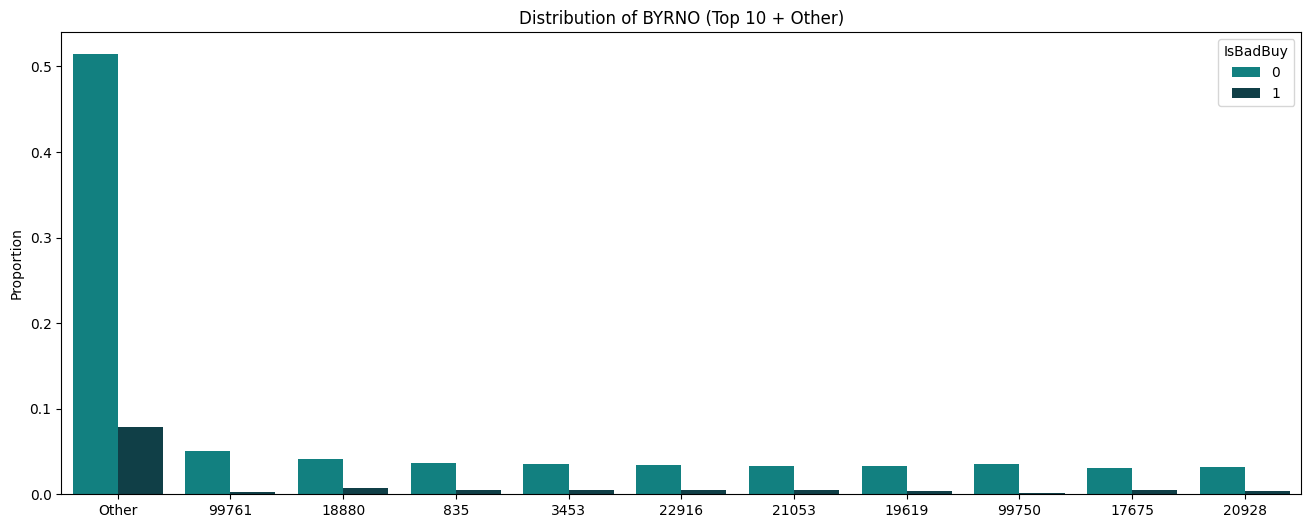

IsBadBuy      0     1
VNZIP1               
27542      3072   330
28273      1606   281
29697      1679   320
32824      3352   347
74135      2182   139
75236      2095   336
80022      1864   254
85040      1829   183
85226      1777   309
95673      1758   212
Other     42793  6265


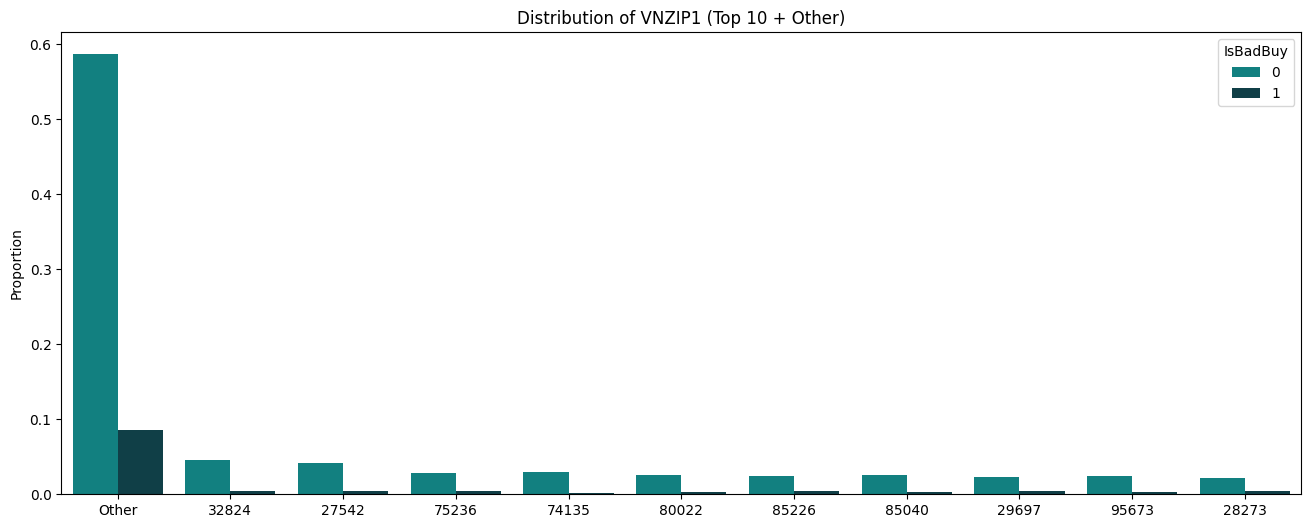

In [5]:
# Hochkardinalen kategoriale Features: Verteilung nach Zielvariable
high_cardinality_categorical_features = [
    "Make", 
    "Color", 
    "Size", 
    "VNST", 
    "Model", 
    "Trim", 
    "SubModel", 
    "BYRNO", 
    "VNZIP1"]
top_n = 10

for categorical_feature in high_cardinality_categorical_features:
    # Füllen der fehlenden Werte mit "Missing"
    df_col = df[categorical_feature].astype("str").fillna("Missing")

    # Top-N-Kategorien behalten, Rest als "Other" zusammenfassen
    top_n_categories = df_col.value_counts().head(top_n).index
    df_col = df_col.where(df_col.isin(top_n_categories), other="Other")

    # Kreuztabelle
    print(pd.crosstab(df_col, df["IsBadBuy"]))

    # Visualisierung
    plt.figure(figsize=(16, 6))
    palette = ["#009292", "#074650"]
    sns.countplot(
        x=df_col,
        data=df,
        hue="IsBadBuy",
        stat="proportion",
        order=df_col.value_counts().index,
        palette=palette,
    )
    plt.title(f"Distribution of {categorical_feature} (Top {top_n} + Other)")
    plt.xlabel(None)
    plt.ylabel("Proportion")
    plt.show()


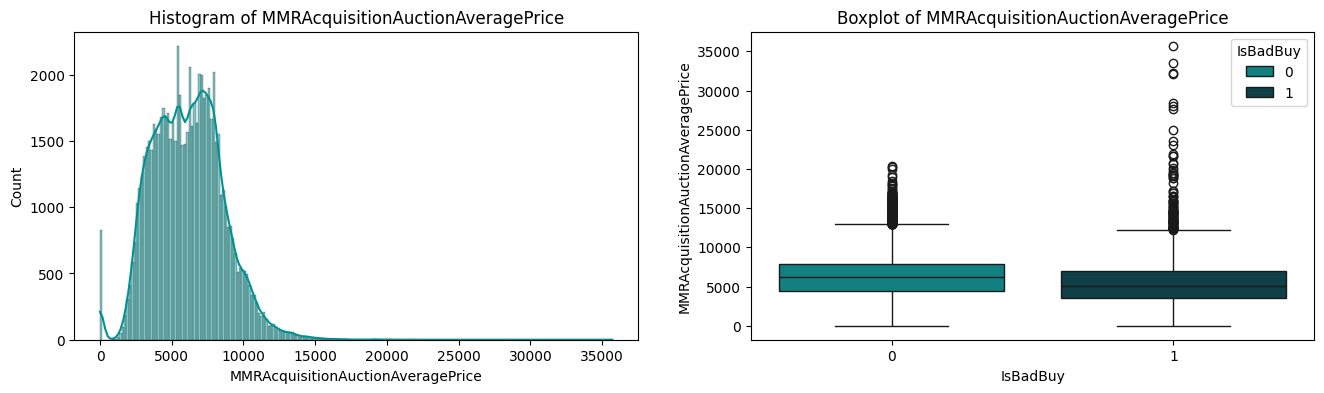

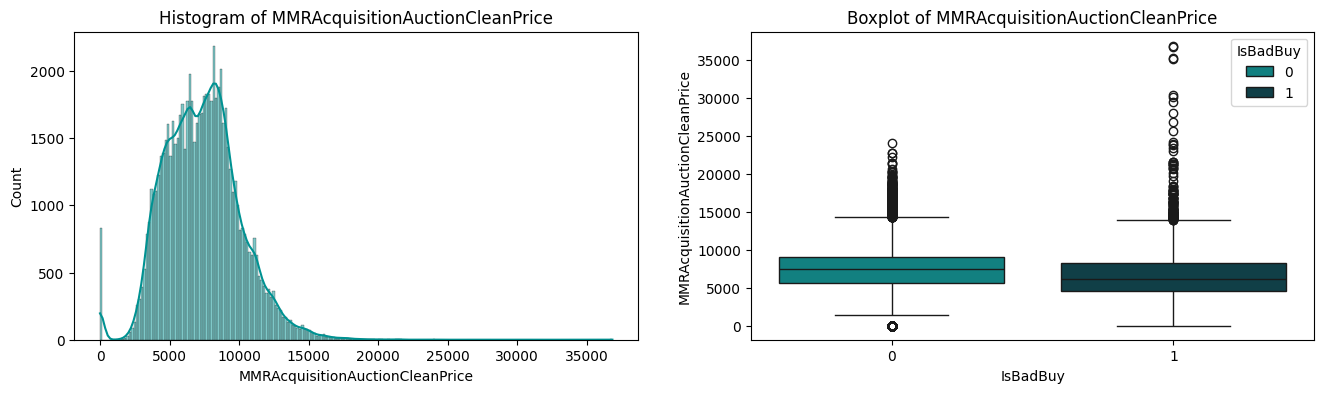

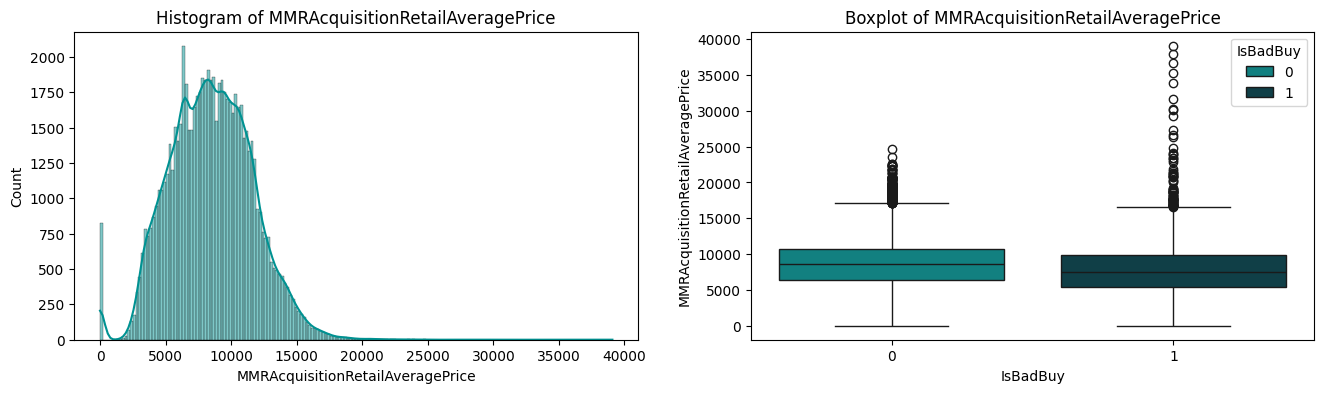

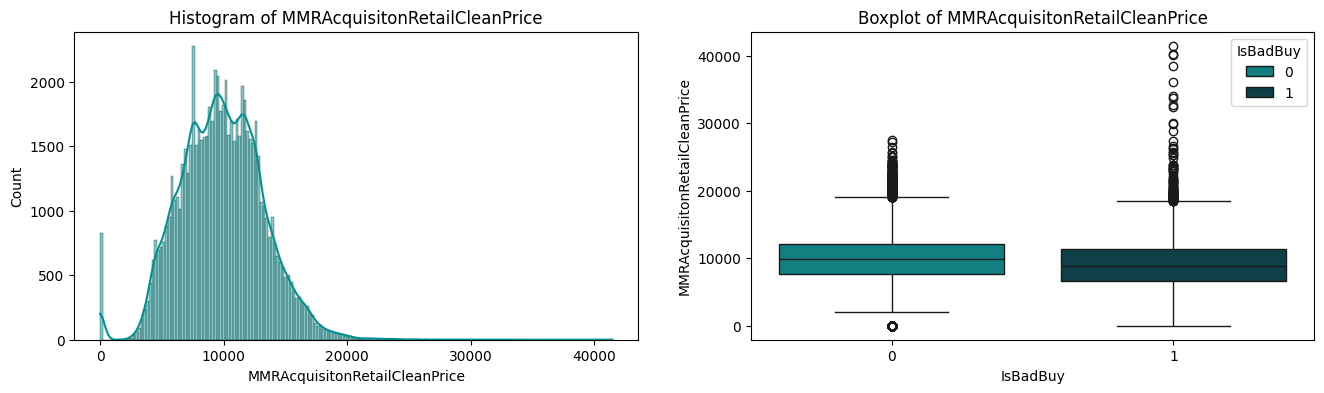

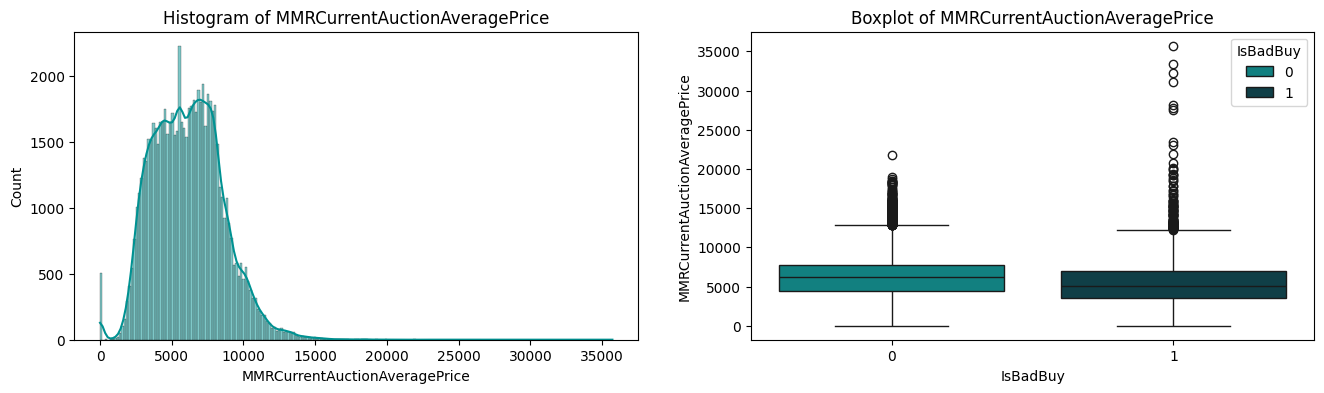

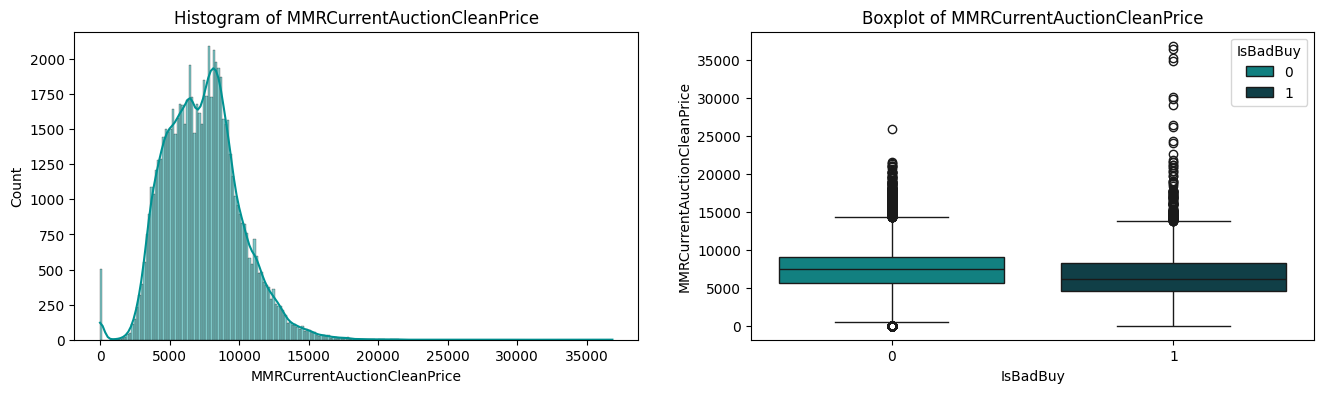

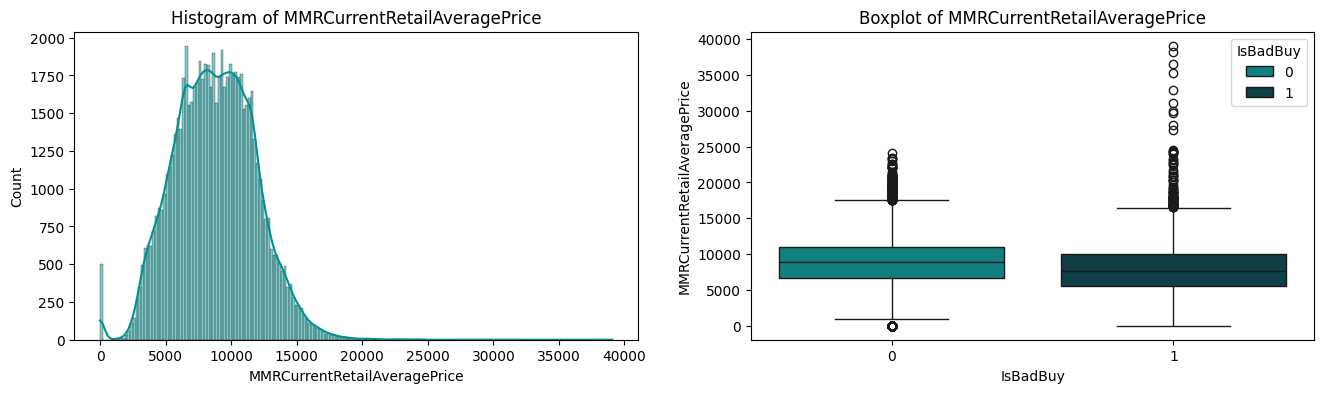

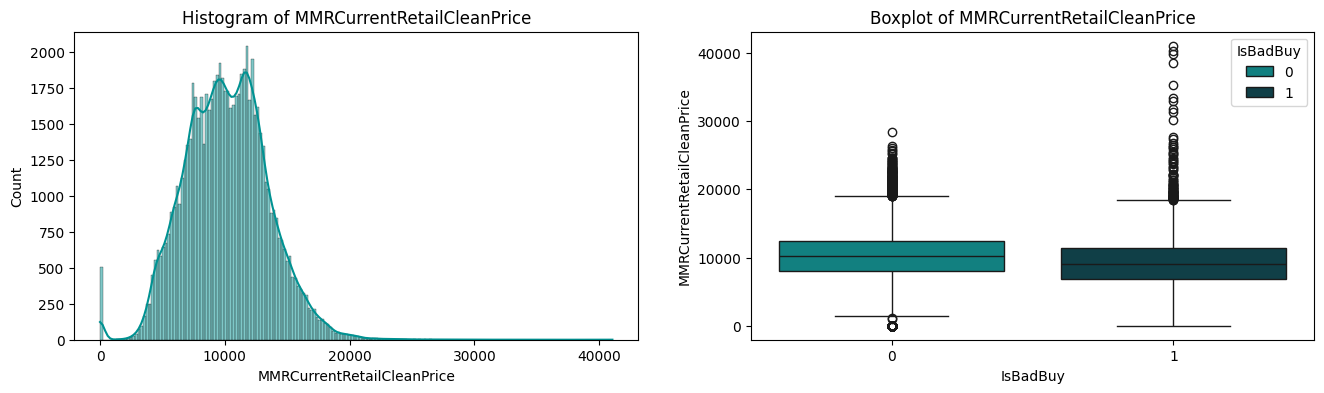

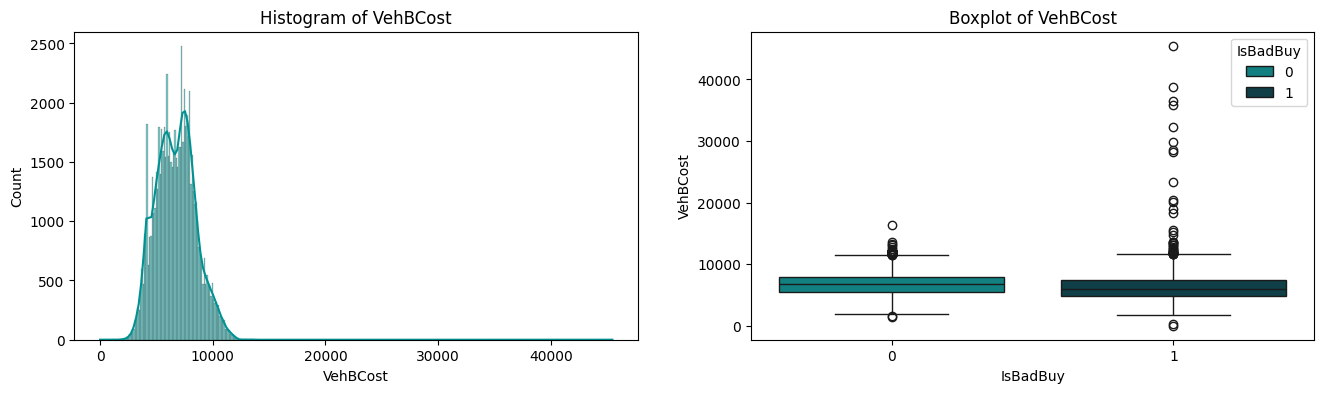

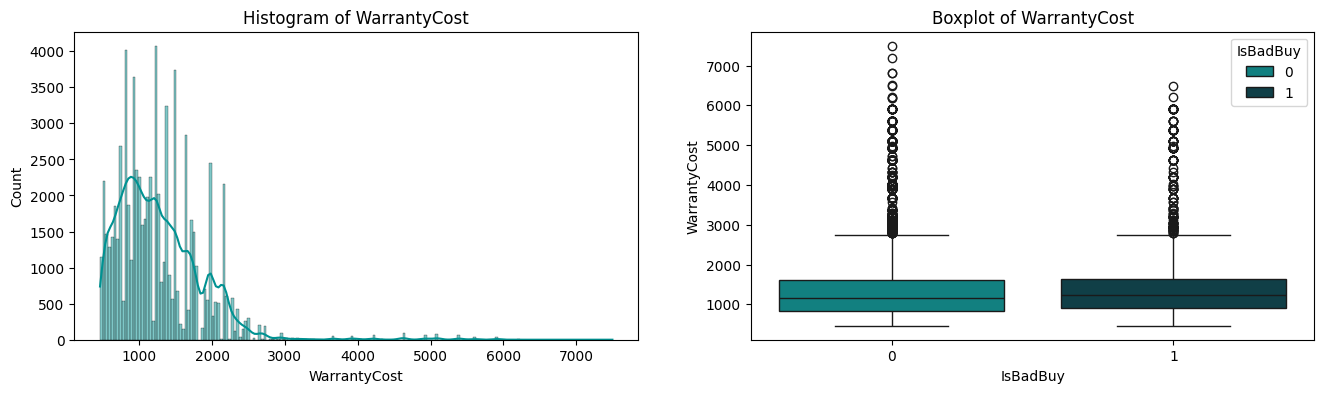

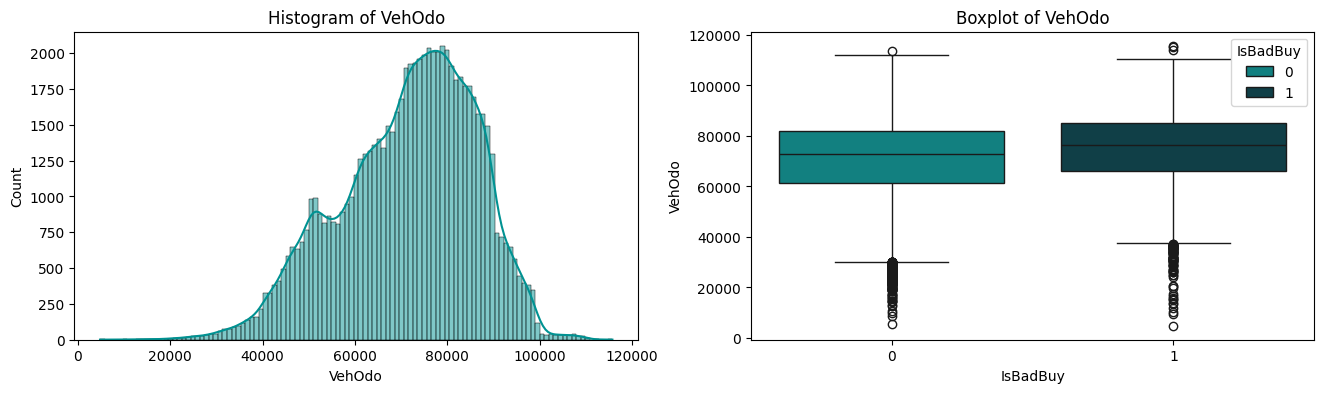

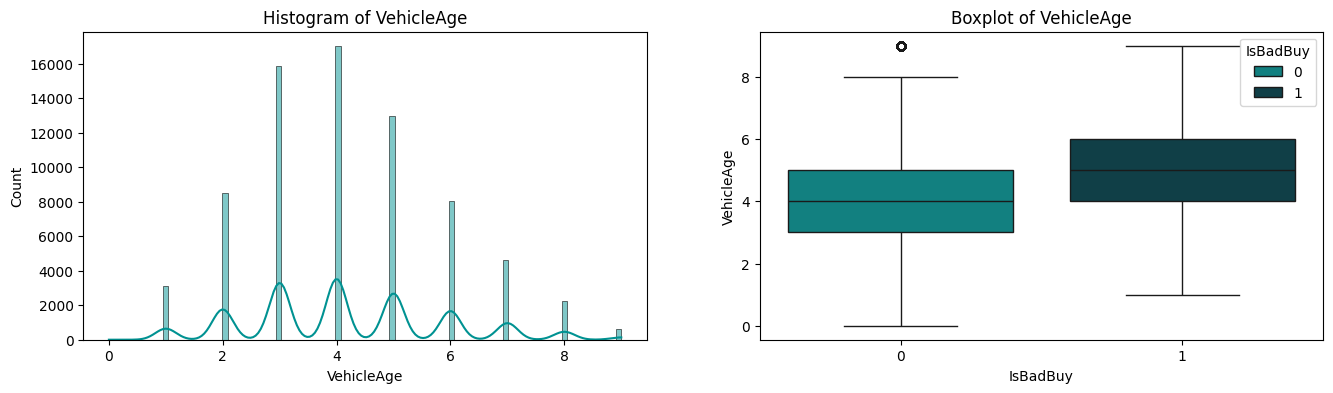

In [6]:
# Numerische Features: Verteilung nach Zielvariable
numerical_features = [
    "MMRAcquisitionAuctionAveragePrice",
    "MMRAcquisitionAuctionCleanPrice",
    "MMRAcquisitionRetailAveragePrice",
    "MMRAcquisitonRetailCleanPrice",
    "MMRCurrentAuctionAveragePrice",
    "MMRCurrentAuctionCleanPrice",
    "MMRCurrentRetailAveragePrice",
    "MMRCurrentRetailCleanPrice",
    "VehBCost",
    "WarrantyCost",
    "VehOdo",
    "VehicleAge",
]

for numerical_feature in numerical_features:
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    palette = ["#009292", "#074650"]

    sns.histplot(
        x=df[numerical_feature], 
        kde=True, ax=axes[0], 
        color=palette[0]
    )
    sns.boxplot(
        data=df, 
        x="IsBadBuy", 
        y=numerical_feature, 
        hue="IsBadBuy", 
        ax=axes[1], 
        palette=palette
    )
    axes[0].set_title(f"Histogram of {numerical_feature}")
    axes[1].set_title(f"Boxplot of {numerical_feature}")
    plt.show()


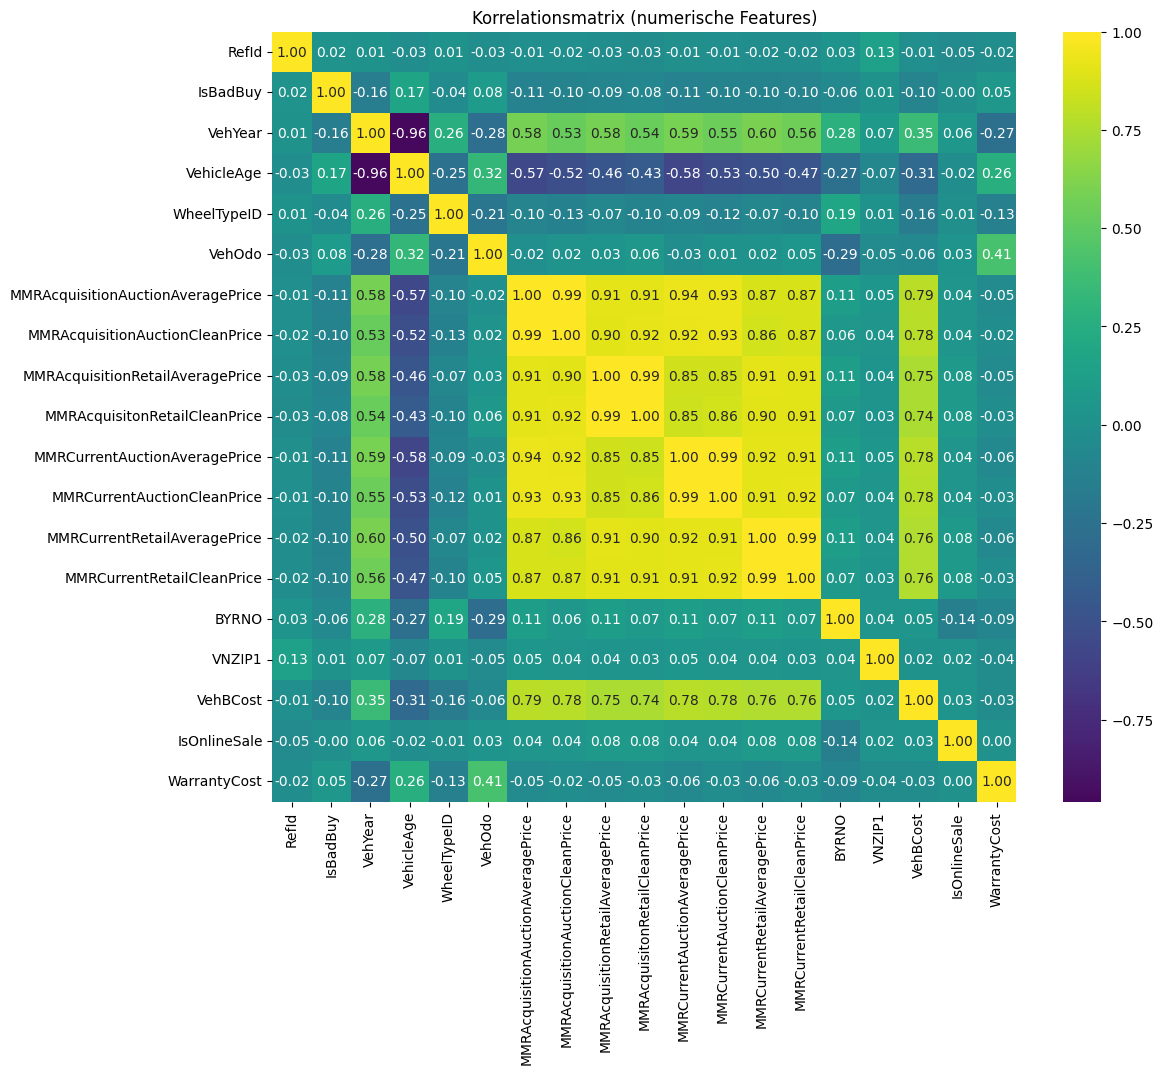

Verteilung des Targets (gesamt):
IsBadBuy
0    0.877012
1    0.122988
Name: proportion, dtype: float64


In [7]:
# Korrelationen
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="viridis", center=0, fmt=".2f")
plt.title("Korrelationsmatrix (numerische Features)")
plt.show()

# Zielverteilung
print("Verteilung des Targets (gesamt):")
print(df["IsBadBuy"].value_counts(normalize=True))

# Split

**Train-Test-Split**

In [8]:
# Train/Test-Split (stratifiziert wegen Klassenungleichgewicht)
target_col = "IsBadBuy"
features = df.drop(columns=target_col)
target = df[target_col]

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    random_state=42,
    test_size=0.1,
    stratify=target
)

# Überprüfung des Train-Test-Splits
print("Dimensionen der Trainingsdaten (Features):", features_train.shape)
print("Dimensionen der Testdaten (Features):", features_test.shape)
print("\nVerteilung des Targets im Trainings-Set:")
print(target_train.value_counts(normalize=True))
print("\nVerteilung des Targets im Test-Set:")
print(target_test.value_counts(normalize=True))

Dimensionen der Trainingsdaten (Features): (65684, 33)
Dimensionen der Testdaten (Features): (7299, 33)

Verteilung des Targets im Trainings-Set:
IsBadBuy
0    0.877017
1    0.122983
Name: proportion, dtype: float64

Verteilung des Targets im Test-Set:
IsBadBuy
0    0.876969
1    0.123031
Name: proportion, dtype: float64


# Data Preparation

**Datatype Transformation**

In [13]:
# Clean data für die Modell-Pipeline vorbereiten
clean_step = FunctionTransformer(
    clean_data, 
    validate=False
)

# Bereinigung und Datentypkonvertierung der Trainings- undd Testdaten
features_train_clean = clean_data(features_train)

# Vergleich Datentypkonvertierung vorher und nachher
dtypes_before = features_train.dtypes
dtypes_after = features_train_clean.dtypes
dtype_comparison = pd.DataFrame({"dtypes_before": dtypes_before, "dtypes_after": dtypes_after})
display(dtype_comparison)

,dtypes_before,dtypes_after
RefId,int64,int64
PurchDate,object,datetime64[ns]
Auction,object,object
VehYear,int64,int64
VehicleAge,int64,int64
Make,object,object
Model,object,object
Trim,object,object
SubModel,object,object
Color,object,object


**Data Imputation**

In [12]:
# Feature Engineering auf bereinigte Daten anwenden
features_train_engineered = engineer_features(features_train_clean)

# Features trennen in numerische und kategoriale Spalten
numeric_features = features_train_engineered.select_dtypes(include=np.number).columns.tolist()
categorical_features = features_train_engineered.select_dtypes(include="object").columns.tolist()

# Kategorische Feature-Gruppen definieren
high_cardinality_categorical_features = [
    "Make",
    "Color",
    "Size",
    "VNST",
    "Model",
    "Trim",
    "SubModel",
    "BYRNO",
    "VNZIP1",
]

high_card_features = [
    col for col in high_cardinality_categorical_features if col in categorical_features
]
low_card_features = [col for col in categorical_features if col not in high_card_features]

mode_features = ["Transmission", "IsOnlineSale"]
low_card_mode_features = [col for col in low_card_features if col in mode_features]
low_card_missing_features = [
    col for col in low_card_features if col not in low_card_mode_features
]

# Imputation testen (ohne Encoding), um fehlende Werte zu kontrollieren
imputer = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
        ("cat_mode", SimpleImputer(strategy="most_frequent"), low_card_mode_features),
        (
            "cat_missing",
            SimpleImputer(strategy="constant", fill_value="Missing"),
            low_card_missing_features + high_card_features,
        ),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

features_train_imputed = imputer.fit_transform(features_train_engineered)

# Vergleich fehlende Werte vor und nach der Imputation
missing_values_before = features_train_engineered.isna().sum()
missing_values_after = features_train_imputed.isna().sum()
missing_values_comparison = pd.DataFrame(
    {
        "missing_values_before": missing_values_before,
        "missing_values_after": missing_values_after,
    }
)
display(missing_values_comparison)

,missing_values_before,missing_values_after
AUCGUART,62622,0.0
Auction,0,0.0
BYRNO,0,0.0
Color,7,0.0
CostPerMile,0,0.0
IsOnlineSale,0,0.0
MMRAcquisitionAuctionAveragePrice,17,0.0
MMRAcquisitionAuctionCleanPrice,17,0.0
MMRAcquisitionRetailAveragePrice,17,0.0
MMRAcquisitonRetailCleanPrice,17,0.0


# Modeling

**Feature Engineering**

In [14]:
# Feature Engineering für die Modell-Pipeline vorbereiten
feature_engineering_step = FunctionTransformer(
    engineer_features,
    validate=False
)

**Feature Selection**

In [15]:
# Feature selection für die Modell-Pipeline vorbereiten
feature_drop = ["PurchDate", "VehYear", "WheelTypeID", "VNZIP1", # redundant
                "BYRNO", # käufer id
                "IsOnlineSale", "Transmission", "Nationality" # feature importance / eda
               ]

feature_selection_step = FunctionTransformer(
    drop_columns, 
    kw_args={'cols_to_drop': feature_drop}, 
    validate=False
)

final_num_features = [col for col in numerical_features if col not in feature_drop]
final_cat_features = [col for col in categorical_features if col not in feature_drop]

**Data Scaling + Dimensonality Reduction**

In [16]:
# PCA-Features definieren und restliche numerische Features bestimmen
pca_cols = [
    "MMRAcquisitionAuctionAveragePrice",
    "MMRAcquisitionAuctionCleanPrice",
    "MMRAcquisitionRetailAveragePrice",
    "MMRAcquisitonRetailCleanPrice",
    "MMRCurrentAuctionAveragePrice",
    "MMRCurrentAuctionCleanPrice",
    "MMRCurrentRetailAveragePrice",
    "MMRCurrentRetailCleanPrice",
]

pca__numeric_features = [col for col in pca_cols if col in final_num_features]
non_pca_numeric_features = [col for col in final_num_features if col not in pca__numeric_features]

**OHE Encoding**

In [17]:
# Kategorische Feature-Gruppen definieren
high_cardinality_categorical_features = [
    "Make",
    "Color",
    "Size",
    "VNST",
    "Model",
    "Trim",
    "SubModel",
    "BYRNO",
    "VNZIP1",
]

high_card_features = [
    col for col in high_cardinality_categorical_features if col in final_cat_features
]
low_card_features = [col for col in final_cat_features if col not in high_card_features]

mode_features = ["Transmission", "IsOnlineSale"]
low_card_mode_features = [col for col in low_card_features if col in mode_features]
low_card_missing_features = [
    col for col in low_card_features if col not in low_card_mode_features
]

**Arbeitsspeicher Optimierung**

In [18]:
# Arbeitsspeicher Optimierung für die Modell-Pipeline vorbereiten
def apply_memory_data(X: pd.DataFrame) -> pd.DataFrame:
    """Wrapper to make memory_data usable in sklearn pipelines."""
    return memory_data(X)

memory_step = FunctionTransformer(apply_memory_data, validate=False)

# Modeling

**Baseline Model**

In [19]:
# Preprocessing- und Modell-Pipeline (inkl. PCA und Resampling)
numeric_transformer_non_pca = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

numeric_transformer_pca = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.95, random_state=42)),
    ]
)

categorical_transformer_low_card_mode = Pipeline(
    steps=[
        ("imputer_mode", SimpleImputer(strategy="most_frequent")),
        ("encoder_mode", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

categorical_transformer_low_card_missing = Pipeline(
    steps=[
        ("imputer_missing", SimpleImputer(strategy="constant", fill_value="Missing")),
        ("encoder_missing", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

categorical_transformer_high_card = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
        ("top_n", TopNCategoriesTransformer(top_n=19)),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_non_pca, non_pca_numeric_features),
        ("pca", numeric_transformer_pca, pca__numeric_features),
        ("cat_high_card", categorical_transformer_high_card, high_card_features),
        ("cat_mode", categorical_transformer_low_card_mode, low_card_mode_features),
        ("cat_missing", categorical_transformer_low_card_missing, low_card_missing_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

model_pipeline = ImbPipeline(
    steps=[
        ("clean", clean_step),
        ("feature_engineering", feature_engineering_step),
        ("preprocess", preprocessor),
        ("memory", memory_step),
        ("sampler", RandomUnderSampler(random_state=42)),
        ("model", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)),
    ]
)

model_pipeline

,steps,"[('clean', ...), ('feature_engineering', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,func,<function cle...001CB289F6B60>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,None
,kw_args,None


**Modell Evaluierung**

In [20]:
# Mehrere Modelle testen
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNeighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []

for model_name, model in models.items():
    model_pipeline = ImbPipeline(
        steps=[
            ("clean", clean_step),
            ("feature_engineering", feature_engineering_step),
            ("feature_selection", feature_selection_step),
            ("preprocess", preprocessor),
            ("sampler", RandomUnderSampler(random_state=42)),
            ("model", model),
        ]
    )

    model_pipeline.fit(features_train, target_train)
    target_test_pred = model_pipeline.predict(features_test)

    results.append(
        {
            "Model": model_name,
            "Precision": precision_score(target_test, target_test_pred),
            "Recall": recall_score(target_test, target_test_pred),
            "F1": f1_score(target_test, target_test_pred),
        }
    )

results_df = pd.DataFrame(results).sort_values(by="Recall", ascending=False)
display(results_df)

,Model,Precision,Recall,F1
3,KNeighbors,0.200928,0.626949,0.304324
4,XGBoost,0.235343,0.625835,0.342057
0,RandomForest,0.244009,0.623608,0.350767
2,DecisionTree,0.184202,0.618040,0.283815
1,LogisticRegression,0.254057,0.610245,0.358756


**Optimierung der Hyperparameter mit BayesSearchCV**

In [ ]:
# Pipeline
pipeline_final = ImbPipeline(
        steps=[
            ("clean", clean_step),
            ("feature_engineering", feature_engineering_step),
            ("feature_selection", feature_selection_step),
            ("preprocess", preprocessor),
            ("sampler", RandomUnderSampler(random_state=42)),
            ("model", XGBClassifier(random_state=42)),
        ]
    )

# Suchraum für die Hyperparameter
search_space_xgb = {
    # Anzahl der Bäume
    "model__n_estimators": Integer(50, 500),
    # Maximale Tiefe
    "model__max_depth": Integer(3, 15),
    # Lernrate
    "model__learning_rate": Real(0.01, 0.3, prior='log-uniform'),
    # Instanz-Gewichte
    "model__min_child_weight": Integer(1, 10),
    # Subsample Ratio der Trainingsinstanzen (gegen Overfitting)
    "model__subsample": Real(0.5, 1.0),
    # Subsample Ratio der Spalten pro Baum
    "model__colsample_bytree": Real(0.5, 1.0),
    # Minimum loss reduction (Regularisierung)
    "model__gamma": Real(0, 5)
}

# Stratified K-Fold Cross-Validation
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Bayesianische Optimierung mit BayesSearchCV
bayes_model_final = BayesSearchCV(estimator=pipeline_final,
                               search_spaces=search_space_xgb,
                               n_iter=100,
                               scoring="f1",
                               cv=cv_stratified,
                               n_jobs=-1,
                               random_state=42)

# Fitting auf Trainingsdaten
bayes_model_final.fit(features_train, target_train)

# Bestes Modell
best_model_final = bayes_model_final.best_estimator_

# Vorhersage auf Testdaten
target_test_pred_final = best_model_final.predict(features_test)

print(f"Optimierte Hyperparameter für RandomForestClassifier :\n{bayes_model_final.best_params_}")
print("\nClassification report")
report_final = classification_report(target_test, target_test_pred_final)
print(report_final)

# Speichern des besten Modells (die fertige Pipeline)
joblib.dump(best_model_rf, "best_model_pipeline.pkl")
print("Modell gespeichert.")

Optimierte Hyperparameter für RandomForestClassifier :
OrderedDict({'model__colsample_bytree': 0.5, 'model__gamma': 5.0, 'model__learning_rate': 0.03132048402742593, 'model__max_depth': 4, 'model__min_child_weight': 1, 'model__n_estimators': 308, 'model__subsample': 0.8329409712557365})

Classification report
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      6401
           1       0.26      0.61      0.37       898

    accuracy                           0.74      7299
   macro avg       0.60      0.69      0.60      7299
weighted avg       0.85      0.74      0.78      7299



In [ ]:
# Speichern des besten Modells (die fertige Pipeline)
SAVE_DIR = "data/processed/"
MODEL_FILENAME = "best_xgb_pipeline.pkl"
MODEL_PATH = os.path.join(SAVE_DIR, MODEL_FILENAME)

joblib.dump(best_model_rf, MODEL_PATH)
print("Modell gespeichert.")

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed\\best_xgb_pipeline.pkl'

# Anwendung des Modells auf Zieldaten

In [ ]:
# Trainingsdatei finden
test_file = [f for f in files if "test" in f.lower()][0]

# Einlesen der Daten
df_aim = pd.read_csv("/".join([destination, competition_name, test_file]))
print(df_aim.shape)
display(df_aim.head())

if "RefId" in df_aim.columns:
    test_ids = df_aim["RefId"]
else:
    print("Warnung: Keine 'RefId' Spalte gefunden.")

df_aim["IsBadBuy"] = best_model_rf.predict(df_aim)

print("\nVerteilung des Targets 'IsBadBuy':\n")
print(df_aim["IsBadBuy"].value_counts(),"\n")
print(df_aim["IsBadBuy"].value_counts(normalize=True),"\n")
display(df_aim.head())

(48707, 33)


,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,73015,12/2/2009,ADESA,2005,4,PONTIAC,GRAND PRIX,Bas,4D SEDAN,SILVER,...,8557.0,9752.0,NaN,NaN,18881,30212,GA,6500.0,0,2152
1,73016,12/2/2009,ADESA,2005,4,CHEVROLET,MALIBU V6,LS,4D SEDAN LS,SILVER,...,7562.0,9296.0,NaN,NaN,18111,30212,GA,6300.0,0,1118
2,73017,12/2/2009,ADESA,2006,3,DODGE,DURANGO 2WD V8,Adv,4D SUV 4.7L ADVENTURER,SILVER,...,15340.0,16512.0,NaN,NaN,18111,30212,GA,9700.0,0,1215
3,73018,12/2/2009,ADESA,2002,7,SATURN,L SERIES,L20,4D SEDAN L200,GOLD,...,5725.0,6398.0,NaN,NaN,18881,30212,GA,4150.0,0,1933
4,73019,12/2/2009,ADESA,2007,2,HYUNDAI,ACCENT,GS,2D COUPE GS,BLUE,...,5914.0,7350.0,NaN,NaN,18111,30212,GA,4100.0,0,920



Verteilung des Targets 'IsBadBuy':

IsBadBuy
0    34759
1    13948
Name: count, dtype: int64 

IsBadBuy
0    0.713635
1    0.286365
Name: proportion, dtype: float64 



,RefId,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
0,73015,12/2/2009,ADESA,2005,4,PONTIAC,GRAND PRIX,Bas,4D SEDAN,SILVER,...,9752.0,NaN,NaN,18881,30212,GA,6500.0,0,2152,0
1,73016,12/2/2009,ADESA,2005,4,CHEVROLET,MALIBU V6,LS,4D SEDAN LS,SILVER,...,9296.0,NaN,NaN,18111,30212,GA,6300.0,0,1118,0
2,73017,12/2/2009,ADESA,2006,3,DODGE,DURANGO 2WD V8,Adv,4D SUV 4.7L ADVENTURER,SILVER,...,16512.0,NaN,NaN,18111,30212,GA,9700.0,0,1215,0
3,73018,12/2/2009,ADESA,2002,7,SATURN,L SERIES,L20,4D SEDAN L200,GOLD,...,6398.0,NaN,NaN,18881,30212,GA,4150.0,0,1933,1
4,73019,12/2/2009,ADESA,2007,2,HYUNDAI,ACCENT,GS,2D COUPE GS,BLUE,...,7350.0,NaN,NaN,18111,30212,GA,4100.0,0,920,1


,RefId,IsBadBuy
0,73015,0
1,73016,0
2,73017,0
3,73018,1
4,73019,1


# Model Interpretation